# YOUR PROJECT TITLE

> **Note the following:** 
> 1. This is *not* meant to be an example of an actual **data analysis project**, just an example of how to structure such a project.
> 1. Remember the general advice on structuring and commenting your code
> 1. The `dataproject.py` file includes a function which can be used multiple times in this notebook.

Imports and set magics:

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from matplotlib_venn import venn2
import pydst
dst = pydst.Dst(lang='en')

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# Plotting style 
plt.style.use('seaborn-whitegrid')

# user written modules
import dataproject


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Read and clean data

Import your data, either through an API or manually, and load it. 

In [13]:
dst.get_subjects()

,id,desc,active,hasSubjects
0,1,People,True,True
1,2,Labour and income,True,True
2,3,Economy,True,True
3,4,Social conditions,True,True
4,5,Education and research,True,True
5,6,Business,True,True
6,7,Transport,True,True
7,8,Culture and leisure,True,True
8,9,Environment and energy,True,True
9,19,Other,True,True


In [16]:
tables = dst.get_tables(subjects=['4'])
tables[tables.id == 'BARSEL05']

,id,text,unit,updated,firstPeriod,latestPeriod,active,variables
30,BARSEL05,Cohabiting parents leave before birth and in t...,Days,2022-05-30 08:00:00,2015,2020,True,"[unit, entitlement, mothers education, fathers..."


In [26]:
indk_vars = dst.get_variables(table_id='BARSEL05')
indk_vars

[{'id': '000', 'text': 'Number of couples'},
 {'id': '110',
  'text': 'Child - Number of days with at least one parent on benefits'},
 {'id': '120',
  'text': "Child - Number of days between parents' first and last day on benefits"},
 {'id': '200',
  'text': 'Mother - total days on parental leave (benefits) on average'},
 {'id': '202',
  'text': 'Mother - days on parental leave (benefits) before birth on average'},
 {'id': '220',
  'text': 'Mother - days on parental leave (benefits) after birth on average'},
 {'id': '330',
  'text': 'Father - days on parental leave (benefits) after birth on average'},
 {'id': '400',
  'text': 'Mother -total days of salary during parental leave on average'},
 {'id': '404',
  'text': 'Mother -days of salary during parental leave before birth on average'},
 {'id': '440',
  'text': 'Mother -days of salary during parental leave after birth on average'},
 {'id': '550',
  'text': 'Father - days of salary during parental leave after birth on average'},
 {'id':

In [21]:
for id in ['TAL','BERET','MORUD','FARUD','OMRÅDE','Tid']:
    print(id)
    values = indk_vars.loc[indk_vars.id == id,['values']].values[0,0]
    for value in values:      
        print(f' id = {value["id"]}, text = {value["text"]}')

TAL
 id = 000, text = Number of couples
 id = 110, text = Child - Number of days with at least one parent on benefits
 id = 120, text = Child - Number of days between parents' first and last day on benefits
 id = 200, text = Mother - total days on parental leave (benefits) on average
 id = 202, text = Mother - days on parental leave (benefits) before birth on average
 id = 220, text = Mother - days on parental leave (benefits) after birth on average
 id = 330, text = Father - days on parental leave (benefits) after birth on average
 id = 400, text = Mother -total days of salary during parental leave on average
 id = 404, text = Mother -days of salary during parental leave before birth on average
 id = 440, text = Mother -days of salary during parental leave after birth on average
 id = 550, text = Father - days of salary during parental leave after birth on average
 id = 600, text = Mother - total days without salary during parental leave on average
 id = 606, text = Mother -days witho

In [109]:
barsel = dst.get_data(table_id = 'BARSEL05', variables={'TAL':['000','202','220','330'], 'BERET':['511'], 'MORUD':['*'], 'FARUD':['*'], 'OMRÅDE':['000'], 'Tid':['*']})
barsel_true = barsel.copy()
barsel_true['TID'] = barsel_true['TID'].astype(int)
barsel_true['INDHOLD'] = barsel_true['INDHOLD'].astype(float)

# Plot data

In [110]:
Mother_all = barsel_true[(barsel_true['FARUD'] == 'All fathers, regardless of education') 
                          & (barsel_true['MORUD'] == 'All mothers, regardless of education') 
                          & (barsel_true['TAL'] == 'Mother - days on parental leave (benefits) after birth on average') ]
Mother_all = Mother_all[['TID', 'INDHOLD']]

Father_all = barsel_true[(barsel_true['MORUD'] == 'All mothers, regardless of education') 
                          & (barsel_true['FARUD'] == 'All fathers, regardless of education') 
                          & (barsel_true['TAL'] == 'Father - days on parental leave (benefits) after birth on average') ]
Father_all = Father_all[['TID', 'INDHOLD']]

Text(0.5, 0, 'Year')

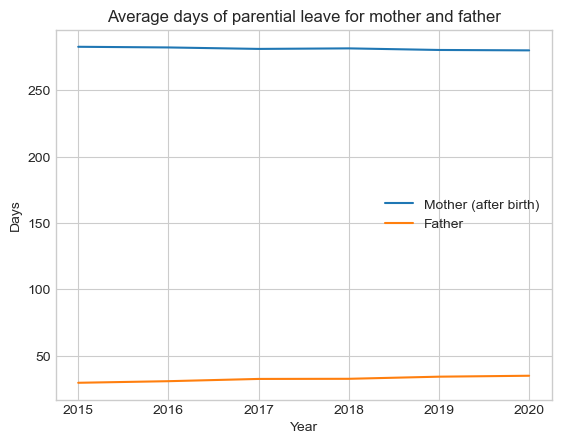

In [122]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
Mother_all.plot(x = 'TID', y = 'INDHOLD', ax=ax, label = 'Mother (after birth)')
Father_all.plot(x = 'TID', y = 'INDHOLD', ax=ax, label = 'Father')
ax.set_title('Average days of parential leave for mother and father')
ax.set_ylabel('Days')
ax.set_xlabel('Year')

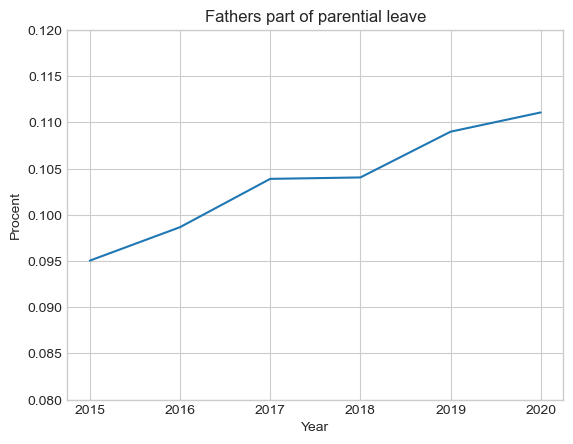

In [133]:
Father_part = Mother_all.copy()
Father_part = pd.merge(Father_part, Father_all, how = 'left', on = 'TID')
Father_part.columns = ['TID', 'mother', 'father']
Father_part['INDHOLD'] = Father_part['father']/(Father_part['father'] + Father_part['mother'])

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
Father_part.plot(x = 'TID', y = 'INDHOLD', ax=ax)
ax.set_title('Fathers part of parential leave')
ax.set_ylabel('Procent')
ax.set_xlabel('Year')
ax.set_ylim(0.08, 0.12)
ax.legend().remove()

In [139]:
Father_educ = barsel_true[barsel_true['MORUD'] == 'All mothers, regardless of education']
Father_educ = Father_educ[(Father_educ['TAL'] != 'Number of couples') 
                           & (Father_educ['TAL'] != 'Mother - days on parental leave (benefits) after birth on average') 
                           & (Father_educ['TAL'] != 'Mother - days on parental leave (benefits) before birth on average')
                           & (Father_educ['FARUD'] != 'All fathers, regardless of education')]
Father_educ = Father_educ[['FARUD', 'TID', 'INDHOLD']]

In [140]:
Mother_educ = barsel_true[barsel_true['FARUD'] == 'All fathers, regardless of education']
Mother_educ = Mother_educ[(Mother_educ['TAL'] != 'Number of couples') 
                           & (Mother_educ['TAL'] != 'Father - days on parental leave (benefits) after birth on average') 
                           & (Mother_educ['TAL'] != 'Mother - days on parental leave (benefits) before birth on average') 
                           & (Mother_educ['MORUD'] != 'All mothers, regardless of education')]
Mother_educ = Mother_educ[['MORUD', 'TID', 'INDHOLD']]

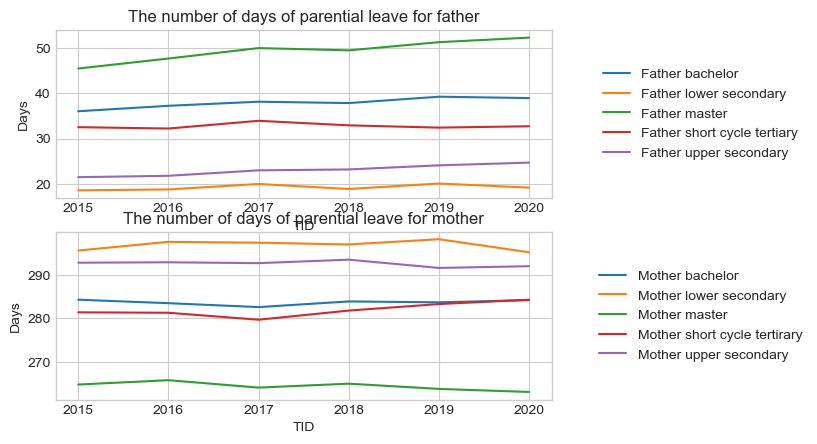

In [147]:
fig = plt.figure()

ax = fig.add_subplot(2,1,1)
for label, group in Father_educ.groupby(['FARUD']):
    group.plot(x='TID', y='INDHOLD', ax=ax, style='-', label=label)
ax.set_ylabel('Days')
ax.set_title('The number of days of parential leave for father');
ax.legend(loc = 'center', bbox_to_anchor=(1.3,0.5))

ax1 = fig.add_subplot(2,1,2)
for label, group in Mother_educ.groupby(['MORUD']):
    group.plot(x='TID', y='INDHOLD', ax=ax1, style='-', label=label)
ax1.set_ylabel('Days')
ax1.set_title('The number of days of parential leave for mother');
ax1.legend(loc = 'center', bbox_to_anchor=(1.3,0.5))